# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [3]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

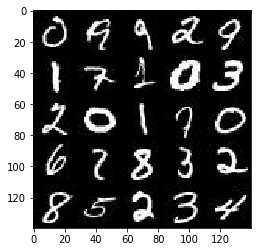

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

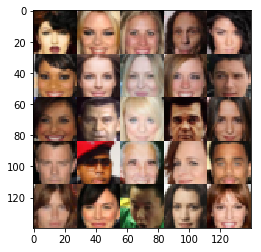

In [5]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [6]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [7]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    image = tf.placeholder(tf.float32, shape=(None,image_width, image_height, image_channels))
    Zinput = tf.placeholder(tf.float32, shape=(None, z_dim))
    learn_rate = tf.placeholder(tf.float32, shape=None)


    return image, Zinput, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [8]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128

        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x2, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256
        
        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [9]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        
        x1 = tf.layers.dense(z, 4*4*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        #logits = tf.layers.batch_normalization(logits, training=is_train) # can be removed

        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)* 0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)* 0.9))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)* 0.9))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [17]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model    
    image, Zinput, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
        
    d_loss, g_loss = model_loss(image, Zinput, data_shape[3])
    
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
        
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                #for x, y in dataset.batches(batch_size):
                steps += 1
                # TODO: Train Model
                #batch_images = batch_images.reshape(batch_size, data_shape[1], data_shape[2], data_shape[3])
                batch_images = batch_images*2
                
                # Sample random noise for G
                batch_z = np.random.uniform(low =-1, high = 1, size=(batch_size, z_dim))

                _ = sess.run(d_train_opt, feed_dict={image: batch_images, Zinput: batch_z, learn_rate: learning_rate})

                _ = sess.run(g_train_opt, feed_dict={image: batch_images, Zinput: batch_z, learn_rate: learning_rate})

                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({image: batch_images, Zinput: batch_z})
                    train_loss_g = g_loss.eval({Zinput: batch_z, image: batch_images})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 10, Zinput, data_shape[3], data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.


Epoch 1/2... Discriminator Loss: 1.5553... Generator Loss: 0.5640
Epoch 1/2... Discriminator Loss: 1.4996... Generator Loss: 0.6181
Epoch 1/2... Discriminator Loss: 1.2897... Generator Loss: 0.7066
Epoch 1/2... Discriminator Loss: 1.2931... Generator Loss: 0.7513
Epoch 1/2... Discriminator Loss: 1.2433... Generator Loss: 0.8036
Epoch 1/2... Discriminator Loss: 1.2390... Generator Loss: 0.7807
Epoch 1/2... Discriminator Loss: 1.2221... Generator Loss: 0.8088
Epoch 1/2... Discriminator Loss: 1.3286... Generator Loss: 0.7917
Epoch 1/2... Discriminator Loss: 1.3656... Generator Loss: 0.7122
Epoch 1/2... Discriminator Loss: 1.2895... Generator Loss: 0.8313


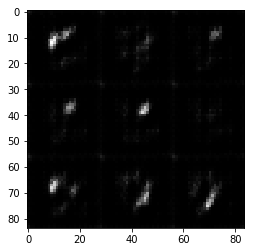

Epoch 1/2... Discriminator Loss: 1.2872... Generator Loss: 0.7691
Epoch 1/2... Discriminator Loss: 1.3646... Generator Loss: 0.7249
Epoch 1/2... Discriminator Loss: 1.2660... Generator Loss: 0.8326
Epoch 1/2... Discriminator Loss: 1.2887... Generator Loss: 0.7598
Epoch 1/2... Discriminator Loss: 1.3118... Generator Loss: 0.8120
Epoch 1/2... Discriminator Loss: 1.2765... Generator Loss: 0.8431
Epoch 1/2... Discriminator Loss: 1.3158... Generator Loss: 0.8160
Epoch 1/2... Discriminator Loss: 1.3125... Generator Loss: 0.7251
Epoch 1/2... Discriminator Loss: 1.2690... Generator Loss: 0.8505
Epoch 1/2... Discriminator Loss: 1.2788... Generator Loss: 0.8471


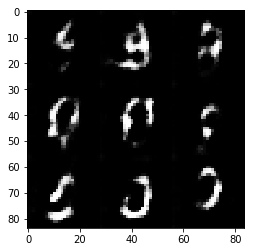

Epoch 1/2... Discriminator Loss: 1.2654... Generator Loss: 0.7844
Epoch 1/2... Discriminator Loss: 1.2897... Generator Loss: 0.8404
Epoch 1/2... Discriminator Loss: 1.2673... Generator Loss: 0.8080
Epoch 1/2... Discriminator Loss: 1.2655... Generator Loss: 0.8651
Epoch 1/2... Discriminator Loss: 1.2536... Generator Loss: 0.8388
Epoch 1/2... Discriminator Loss: 1.2761... Generator Loss: 0.7805
Epoch 1/2... Discriminator Loss: 1.2714... Generator Loss: 0.8831
Epoch 1/2... Discriminator Loss: 1.2582... Generator Loss: 0.8266
Epoch 1/2... Discriminator Loss: 1.3040... Generator Loss: 0.8013
Epoch 1/2... Discriminator Loss: 1.2510... Generator Loss: 0.8275


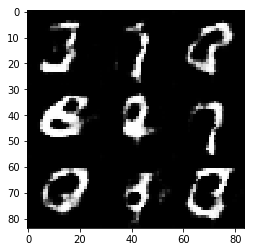

Epoch 1/2... Discriminator Loss: 1.2772... Generator Loss: 0.8371
Epoch 1/2... Discriminator Loss: 1.2617... Generator Loss: 0.8616
Epoch 1/2... Discriminator Loss: 1.3087... Generator Loss: 0.7593
Epoch 1/2... Discriminator Loss: 1.2261... Generator Loss: 0.8649
Epoch 1/2... Discriminator Loss: 1.2751... Generator Loss: 0.7705
Epoch 1/2... Discriminator Loss: 1.2291... Generator Loss: 0.8598
Epoch 1/2... Discriminator Loss: 1.2841... Generator Loss: 0.7828
Epoch 1/2... Discriminator Loss: 1.2759... Generator Loss: 0.7961
Epoch 1/2... Discriminator Loss: 1.2904... Generator Loss: 0.8386
Epoch 1/2... Discriminator Loss: 1.3289... Generator Loss: 0.7524


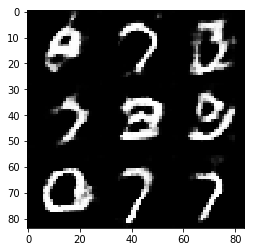

Epoch 1/2... Discriminator Loss: 1.3007... Generator Loss: 0.7667
Epoch 1/2... Discriminator Loss: 1.2495... Generator Loss: 0.8439
Epoch 1/2... Discriminator Loss: 1.2863... Generator Loss: 0.8062
Epoch 1/2... Discriminator Loss: 1.2667... Generator Loss: 0.7854
Epoch 1/2... Discriminator Loss: 1.2858... Generator Loss: 0.7553
Epoch 1/2... Discriminator Loss: 1.3126... Generator Loss: 0.7338
Epoch 1/2... Discriminator Loss: 1.2842... Generator Loss: 0.7730
Epoch 1/2... Discriminator Loss: 1.3278... Generator Loss: 0.7563
Epoch 1/2... Discriminator Loss: 1.3066... Generator Loss: 0.7446
Epoch 1/2... Discriminator Loss: 1.3199... Generator Loss: 0.7430


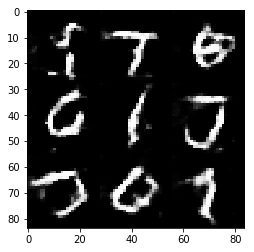

Epoch 1/2... Discriminator Loss: 1.2587... Generator Loss: 0.8673
Epoch 1/2... Discriminator Loss: 1.3071... Generator Loss: 0.8168
Epoch 1/2... Discriminator Loss: 1.3125... Generator Loss: 0.8062
Epoch 1/2... Discriminator Loss: 1.3002... Generator Loss: 0.7680
Epoch 1/2... Discriminator Loss: 1.2867... Generator Loss: 0.7952
Epoch 1/2... Discriminator Loss: 1.3562... Generator Loss: 0.8440
Epoch 1/2... Discriminator Loss: 1.3040... Generator Loss: 0.7956
Epoch 1/2... Discriminator Loss: 1.3104... Generator Loss: 0.8217
Epoch 1/2... Discriminator Loss: 1.2928... Generator Loss: 0.7629
Epoch 1/2... Discriminator Loss: 1.2842... Generator Loss: 0.8030


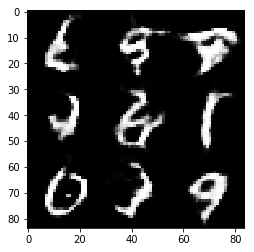

Epoch 1/2... Discriminator Loss: 1.2789... Generator Loss: 0.7324
Epoch 1/2... Discriminator Loss: 1.2843... Generator Loss: 0.8267
Epoch 1/2... Discriminator Loss: 1.1967... Generator Loss: 0.8877
Epoch 1/2... Discriminator Loss: 1.2778... Generator Loss: 0.8228
Epoch 1/2... Discriminator Loss: 1.2650... Generator Loss: 0.7292
Epoch 1/2... Discriminator Loss: 1.2587... Generator Loss: 0.7886
Epoch 1/2... Discriminator Loss: 1.2419... Generator Loss: 0.8730
Epoch 1/2... Discriminator Loss: 1.2454... Generator Loss: 0.8278
Epoch 1/2... Discriminator Loss: 1.2322... Generator Loss: 0.8424
Epoch 1/2... Discriminator Loss: 1.2779... Generator Loss: 0.7897


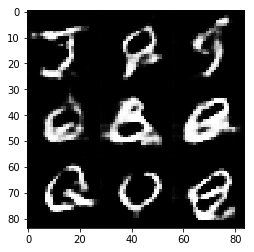

Epoch 1/2... Discriminator Loss: 1.2949... Generator Loss: 0.8805
Epoch 1/2... Discriminator Loss: 1.3323... Generator Loss: 0.9932
Epoch 1/2... Discriminator Loss: 1.2271... Generator Loss: 0.9119
Epoch 1/2... Discriminator Loss: 1.4056... Generator Loss: 0.9797
Epoch 1/2... Discriminator Loss: 1.2816... Generator Loss: 0.8515
Epoch 1/2... Discriminator Loss: 1.2708... Generator Loss: 0.8316
Epoch 1/2... Discriminator Loss: 1.2749... Generator Loss: 0.8158
Epoch 1/2... Discriminator Loss: 1.2788... Generator Loss: 0.8221
Epoch 1/2... Discriminator Loss: 1.2823... Generator Loss: 0.8212
Epoch 1/2... Discriminator Loss: 1.2049... Generator Loss: 0.8374


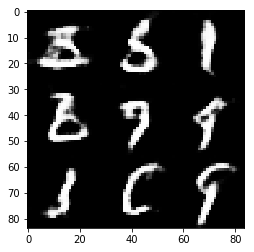

Epoch 1/2... Discriminator Loss: 1.2442... Generator Loss: 0.8830
Epoch 1/2... Discriminator Loss: 1.2843... Generator Loss: 0.9157
Epoch 1/2... Discriminator Loss: 1.2595... Generator Loss: 0.8778
Epoch 1/2... Discriminator Loss: 1.2604... Generator Loss: 0.8606
Epoch 1/2... Discriminator Loss: 1.2635... Generator Loss: 0.8280
Epoch 1/2... Discriminator Loss: 1.2158... Generator Loss: 0.7756
Epoch 1/2... Discriminator Loss: 1.2635... Generator Loss: 0.7466
Epoch 1/2... Discriminator Loss: 1.1956... Generator Loss: 0.8638
Epoch 1/2... Discriminator Loss: 1.2270... Generator Loss: 0.9027
Epoch 1/2... Discriminator Loss: 1.3305... Generator Loss: 0.8782


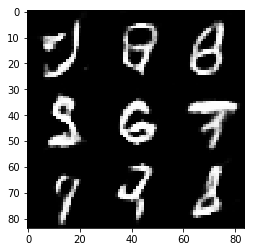

Epoch 1/2... Discriminator Loss: 1.2499... Generator Loss: 0.7770
Epoch 1/2... Discriminator Loss: 1.2319... Generator Loss: 0.8714
Epoch 1/2... Discriminator Loss: 1.2451... Generator Loss: 0.8537
Epoch 2/2... Discriminator Loss: 1.3135... Generator Loss: 0.9999
Epoch 2/2... Discriminator Loss: 1.2595... Generator Loss: 0.8643
Epoch 2/2... Discriminator Loss: 1.5333... Generator Loss: 0.5434
Epoch 2/2... Discriminator Loss: 1.2614... Generator Loss: 0.7216
Epoch 2/2... Discriminator Loss: 1.2503... Generator Loss: 0.8669
Epoch 2/2... Discriminator Loss: 1.1686... Generator Loss: 0.9709
Epoch 2/2... Discriminator Loss: 1.1908... Generator Loss: 0.8817


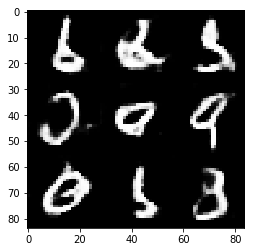

Epoch 2/2... Discriminator Loss: 1.1743... Generator Loss: 0.9784
Epoch 2/2... Discriminator Loss: 1.1960... Generator Loss: 0.8709
Epoch 2/2... Discriminator Loss: 1.2534... Generator Loss: 0.7097
Epoch 2/2... Discriminator Loss: 1.2688... Generator Loss: 0.8472
Epoch 2/2... Discriminator Loss: 1.1849... Generator Loss: 0.9161
Epoch 2/2... Discriminator Loss: 1.2230... Generator Loss: 0.8069
Epoch 2/2... Discriminator Loss: 1.2068... Generator Loss: 0.8730
Epoch 2/2... Discriminator Loss: 1.2444... Generator Loss: 0.9534
Epoch 2/2... Discriminator Loss: 1.2147... Generator Loss: 1.0839
Epoch 2/2... Discriminator Loss: 1.2252... Generator Loss: 0.8703


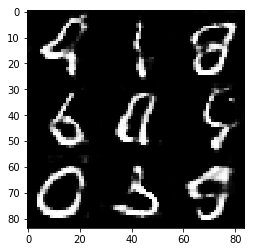

Epoch 2/2... Discriminator Loss: 1.2607... Generator Loss: 0.9271
Epoch 2/2... Discriminator Loss: 1.2269... Generator Loss: 0.9271
Epoch 2/2... Discriminator Loss: 1.2880... Generator Loss: 0.6890
Epoch 2/2... Discriminator Loss: 1.2364... Generator Loss: 0.8263
Epoch 2/2... Discriminator Loss: 1.2995... Generator Loss: 0.7352
Epoch 2/2... Discriminator Loss: 1.2457... Generator Loss: 1.0902
Epoch 2/2... Discriminator Loss: 1.1907... Generator Loss: 0.8985
Epoch 2/2... Discriminator Loss: 1.1913... Generator Loss: 0.9269
Epoch 2/2... Discriminator Loss: 1.1853... Generator Loss: 0.7856
Epoch 2/2... Discriminator Loss: 1.2149... Generator Loss: 1.1159


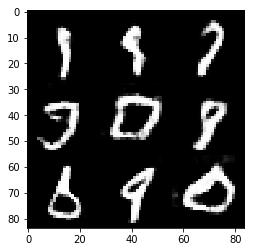

Epoch 2/2... Discriminator Loss: 1.2239... Generator Loss: 0.7710
Epoch 2/2... Discriminator Loss: 1.2524... Generator Loss: 0.8805
Epoch 2/2... Discriminator Loss: 1.2856... Generator Loss: 0.8081
Epoch 2/2... Discriminator Loss: 1.2900... Generator Loss: 0.8138
Epoch 2/2... Discriminator Loss: 1.2260... Generator Loss: 0.8436
Epoch 2/2... Discriminator Loss: 1.2630... Generator Loss: 0.9824
Epoch 2/2... Discriminator Loss: 1.1869... Generator Loss: 0.9723
Epoch 2/2... Discriminator Loss: 1.3151... Generator Loss: 1.0651
Epoch 2/2... Discriminator Loss: 1.1674... Generator Loss: 1.0356
Epoch 2/2... Discriminator Loss: 1.1706... Generator Loss: 0.8652


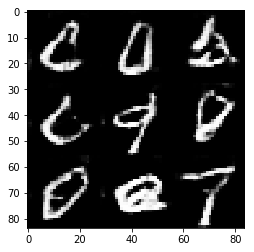

Epoch 2/2... Discriminator Loss: 1.1749... Generator Loss: 0.8482
Epoch 2/2... Discriminator Loss: 1.2058... Generator Loss: 0.9722
Epoch 2/2... Discriminator Loss: 1.2048... Generator Loss: 0.8835
Epoch 2/2... Discriminator Loss: 1.2816... Generator Loss: 1.0554
Epoch 2/2... Discriminator Loss: 1.1724... Generator Loss: 0.8554
Epoch 2/2... Discriminator Loss: 1.1406... Generator Loss: 0.9339
Epoch 2/2... Discriminator Loss: 1.3459... Generator Loss: 1.1203
Epoch 2/2... Discriminator Loss: 1.2197... Generator Loss: 0.8072
Epoch 2/2... Discriminator Loss: 1.1668... Generator Loss: 0.9375
Epoch 2/2... Discriminator Loss: 1.2247... Generator Loss: 1.0610


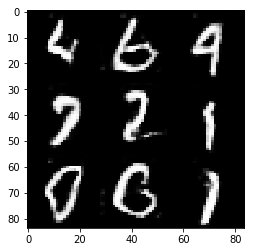

Epoch 2/2... Discriminator Loss: 1.1931... Generator Loss: 0.8392
Epoch 2/2... Discriminator Loss: 1.1908... Generator Loss: 0.8581
Epoch 2/2... Discriminator Loss: 1.2312... Generator Loss: 0.9954
Epoch 2/2... Discriminator Loss: 1.2135... Generator Loss: 0.8811
Epoch 2/2... Discriminator Loss: 1.2114... Generator Loss: 0.7534
Epoch 2/2... Discriminator Loss: 1.2208... Generator Loss: 0.9359
Epoch 2/2... Discriminator Loss: 1.1531... Generator Loss: 0.9441
Epoch 2/2... Discriminator Loss: 1.2497... Generator Loss: 1.0451
Epoch 2/2... Discriminator Loss: 1.2148... Generator Loss: 0.8728
Epoch 2/2... Discriminator Loss: 1.2398... Generator Loss: 0.7917


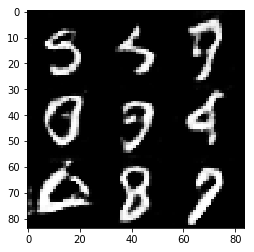

Epoch 2/2... Discriminator Loss: 1.2074... Generator Loss: 0.8242
Epoch 2/2... Discriminator Loss: 1.1975... Generator Loss: 0.8806
Epoch 2/2... Discriminator Loss: 1.1900... Generator Loss: 0.8331
Epoch 2/2... Discriminator Loss: 1.2889... Generator Loss: 0.8723
Epoch 2/2... Discriminator Loss: 1.1823... Generator Loss: 0.8393
Epoch 2/2... Discriminator Loss: 1.2035... Generator Loss: 0.8493
Epoch 2/2... Discriminator Loss: 1.2208... Generator Loss: 0.7812
Epoch 2/2... Discriminator Loss: 1.2057... Generator Loss: 0.9575
Epoch 2/2... Discriminator Loss: 1.2949... Generator Loss: 0.9407
Epoch 2/2... Discriminator Loss: 1.1544... Generator Loss: 0.8611


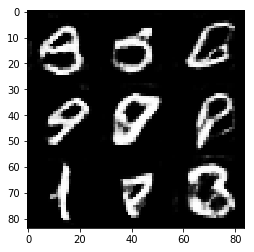

Epoch 2/2... Discriminator Loss: 1.2174... Generator Loss: 1.0852
Epoch 2/2... Discriminator Loss: 1.2224... Generator Loss: 0.8153
Epoch 2/2... Discriminator Loss: 1.2566... Generator Loss: 0.9913
Epoch 2/2... Discriminator Loss: 1.1799... Generator Loss: 0.8594
Epoch 2/2... Discriminator Loss: 1.1461... Generator Loss: 0.9608
Epoch 2/2... Discriminator Loss: 1.2711... Generator Loss: 0.6813
Epoch 2/2... Discriminator Loss: 1.1964... Generator Loss: 0.8372
Epoch 2/2... Discriminator Loss: 1.1855... Generator Loss: 1.0369
Epoch 2/2... Discriminator Loss: 1.1722... Generator Loss: 0.9788
Epoch 2/2... Discriminator Loss: 1.2838... Generator Loss: 0.8342


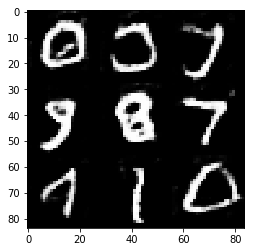

Epoch 2/2... Discriminator Loss: 1.1777... Generator Loss: 1.0317
Epoch 2/2... Discriminator Loss: 1.1612... Generator Loss: 0.9937
Epoch 2/2... Discriminator Loss: 1.1724... Generator Loss: 0.9652
Epoch 2/2... Discriminator Loss: 1.3023... Generator Loss: 0.9139
Epoch 2/2... Discriminator Loss: 1.1704... Generator Loss: 0.8727
Epoch 2/2... Discriminator Loss: 1.1417... Generator Loss: 1.0028
Epoch 2/2... Discriminator Loss: 1.2587... Generator Loss: 1.0139
Epoch 2/2... Discriminator Loss: 1.1531... Generator Loss: 0.9955
Epoch 2/2... Discriminator Loss: 1.2970... Generator Loss: 1.0213
Epoch 2/2... Discriminator Loss: 1.1721... Generator Loss: 0.8439


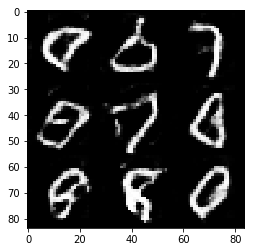

Epoch 2/2... Discriminator Loss: 1.1854... Generator Loss: 0.9737
Epoch 2/2... Discriminator Loss: 1.1350... Generator Loss: 0.8603
Epoch 2/2... Discriminator Loss: 1.2164... Generator Loss: 0.7866
Epoch 2/2... Discriminator Loss: 1.1651... Generator Loss: 0.8599
Epoch 2/2... Discriminator Loss: 1.1731... Generator Loss: 0.7731
Epoch 2/2... Discriminator Loss: 1.1522... Generator Loss: 0.8317
Epoch 2/2... Discriminator Loss: 1.1813... Generator Loss: 0.8617


In [18]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

#print(mnist_dataset.shape)
#print(mnist_dataset.image_mode)

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
print()
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.7742... Generator Loss: 0.4850
Epoch 1/1... Discriminator Loss: 1.3227... Generator Loss: 0.7062
Epoch 1/1... Discriminator Loss: 1.2115... Generator Loss: 0.7679
Epoch 1/1... Discriminator Loss: 0.8769... Generator Loss: 1.1297
Epoch 1/1... Discriminator Loss: 0.7336... Generator Loss: 1.3365
Epoch 1/1... Discriminator Loss: 0.7837... Generator Loss: 1.4489
Epoch 1/1... Discriminator Loss: 0.7327... Generator Loss: 1.3865
Epoch 1/1... Discriminator Loss: 0.7663... Generator Loss: 1.4839
Epoch 1/1... Discriminator Loss: 1.0886... Generator Loss: 0.8181
Epoch 1/1... Discriminator Loss: 0.7237... Generator Loss: 1.4297


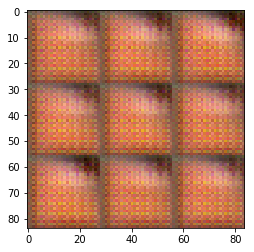

Epoch 1/1... Discriminator Loss: 0.8189... Generator Loss: 1.7245
Epoch 1/1... Discriminator Loss: 0.7917... Generator Loss: 1.4719
Epoch 1/1... Discriminator Loss: 1.0397... Generator Loss: 1.6248
Epoch 1/1... Discriminator Loss: 0.7658... Generator Loss: 1.4880
Epoch 1/1... Discriminator Loss: 0.6932... Generator Loss: 1.5804
Epoch 1/1... Discriminator Loss: 0.7951... Generator Loss: 1.4539
Epoch 1/1... Discriminator Loss: 0.6566... Generator Loss: 1.5824
Epoch 1/1... Discriminator Loss: 0.8122... Generator Loss: 1.0845
Epoch 1/1... Discriminator Loss: 2.8411... Generator Loss: 1.8000
Epoch 1/1... Discriminator Loss: 0.7413... Generator Loss: 1.3863


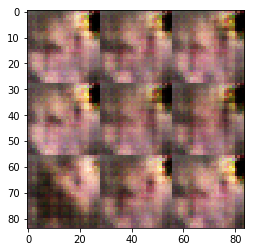

Epoch 1/1... Discriminator Loss: 0.8418... Generator Loss: 1.7179
Epoch 1/1... Discriminator Loss: 1.0517... Generator Loss: 1.2711
Epoch 1/1... Discriminator Loss: 1.0059... Generator Loss: 1.1614
Epoch 1/1... Discriminator Loss: 0.9314... Generator Loss: 1.8741
Epoch 1/1... Discriminator Loss: 1.9564... Generator Loss: 0.8809
Epoch 1/1... Discriminator Loss: 0.9053... Generator Loss: 1.1888
Epoch 1/1... Discriminator Loss: 0.9775... Generator Loss: 1.0939
Epoch 1/1... Discriminator Loss: 0.8509... Generator Loss: 1.3221
Epoch 1/1... Discriminator Loss: 0.9436... Generator Loss: 1.1274
Epoch 1/1... Discriminator Loss: 0.9116... Generator Loss: 1.1161


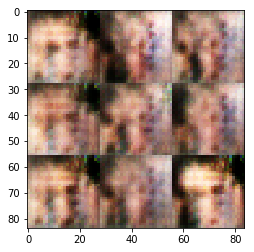

Epoch 1/1... Discriminator Loss: 0.8099... Generator Loss: 1.2724
Epoch 1/1... Discriminator Loss: 1.4092... Generator Loss: 1.3574
Epoch 1/1... Discriminator Loss: 1.1435... Generator Loss: 1.0158
Epoch 1/1... Discriminator Loss: 0.8728... Generator Loss: 1.1323
Epoch 1/1... Discriminator Loss: 0.9585... Generator Loss: 1.1268
Epoch 1/1... Discriminator Loss: 1.1438... Generator Loss: 1.1730
Epoch 1/1... Discriminator Loss: 1.0662... Generator Loss: 0.9775
Epoch 1/1... Discriminator Loss: 1.0744... Generator Loss: 1.0646
Epoch 1/1... Discriminator Loss: 0.9708... Generator Loss: 1.0910
Epoch 1/1... Discriminator Loss: 0.9751... Generator Loss: 1.0753


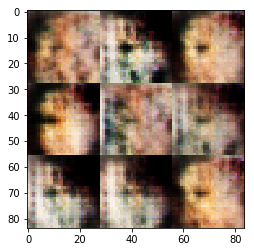

Epoch 1/1... Discriminator Loss: 1.1495... Generator Loss: 1.2701
Epoch 1/1... Discriminator Loss: 0.9457... Generator Loss: 1.1404
Epoch 1/1... Discriminator Loss: 0.8723... Generator Loss: 1.2204
Epoch 1/1... Discriminator Loss: 0.9727... Generator Loss: 1.0169
Epoch 1/1... Discriminator Loss: 0.9681... Generator Loss: 1.2733
Epoch 1/1... Discriminator Loss: 3.4817... Generator Loss: 1.0536
Epoch 1/1... Discriminator Loss: 1.1488... Generator Loss: 1.1836
Epoch 1/1... Discriminator Loss: 1.0205... Generator Loss: 1.0100
Epoch 1/1... Discriminator Loss: 0.9555... Generator Loss: 1.0686
Epoch 1/1... Discriminator Loss: 0.9986... Generator Loss: 1.0322


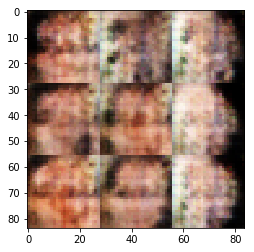

Epoch 1/1... Discriminator Loss: 0.9836... Generator Loss: 1.0814
Epoch 1/1... Discriminator Loss: 0.9933... Generator Loss: 1.0703
Epoch 1/1... Discriminator Loss: 1.0303... Generator Loss: 0.9642
Epoch 1/1... Discriminator Loss: 1.0735... Generator Loss: 0.9923
Epoch 1/1... Discriminator Loss: 1.1341... Generator Loss: 0.9282
Epoch 1/1... Discriminator Loss: 1.2732... Generator Loss: 1.0797
Epoch 1/1... Discriminator Loss: 1.1054... Generator Loss: 1.0597
Epoch 1/1... Discriminator Loss: 1.1951... Generator Loss: 0.9914
Epoch 1/1... Discriminator Loss: 1.0647... Generator Loss: 0.9416
Epoch 1/1... Discriminator Loss: 1.3010... Generator Loss: 1.1443


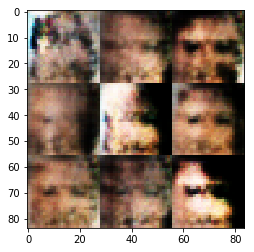

Epoch 1/1... Discriminator Loss: 1.1447... Generator Loss: 0.9769
Epoch 1/1... Discriminator Loss: 1.0885... Generator Loss: 0.9351
Epoch 1/1... Discriminator Loss: 1.1514... Generator Loss: 1.1165
Epoch 1/1... Discriminator Loss: 1.2912... Generator Loss: 0.9407
Epoch 1/1... Discriminator Loss: 1.1077... Generator Loss: 0.9139
Epoch 1/1... Discriminator Loss: 1.0612... Generator Loss: 1.0392
Epoch 1/1... Discriminator Loss: 1.2053... Generator Loss: 0.9813
Epoch 1/1... Discriminator Loss: 1.1617... Generator Loss: 0.9096
Epoch 1/1... Discriminator Loss: 1.0812... Generator Loss: 0.9874
Epoch 1/1... Discriminator Loss: 1.1500... Generator Loss: 0.9014


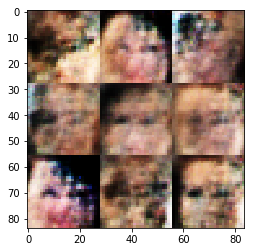

Epoch 1/1... Discriminator Loss: 1.1842... Generator Loss: 1.0441
Epoch 1/1... Discriminator Loss: 1.1643... Generator Loss: 1.0325
Epoch 1/1... Discriminator Loss: 1.1197... Generator Loss: 0.8994
Epoch 1/1... Discriminator Loss: 1.1294... Generator Loss: 0.9800
Epoch 1/1... Discriminator Loss: 1.0604... Generator Loss: 1.0313
Epoch 1/1... Discriminator Loss: 1.1266... Generator Loss: 0.9256
Epoch 1/1... Discriminator Loss: 1.0859... Generator Loss: 1.0192
Epoch 1/1... Discriminator Loss: 1.3016... Generator Loss: 0.9144
Epoch 1/1... Discriminator Loss: 1.7221... Generator Loss: 0.7762
Epoch 1/1... Discriminator Loss: 1.2326... Generator Loss: 0.9317


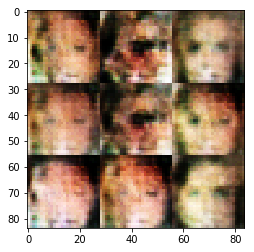

Epoch 1/1... Discriminator Loss: 1.1858... Generator Loss: 0.9808
Epoch 1/1... Discriminator Loss: 1.1695... Generator Loss: 1.0020
Epoch 1/1... Discriminator Loss: 1.1283... Generator Loss: 1.0137
Epoch 1/1... Discriminator Loss: 1.1744... Generator Loss: 0.9023
Epoch 1/1... Discriminator Loss: 1.2506... Generator Loss: 0.9167
Epoch 1/1... Discriminator Loss: 1.1644... Generator Loss: 0.9860
Epoch 1/1... Discriminator Loss: 1.0958... Generator Loss: 0.9689
Epoch 1/1... Discriminator Loss: 1.2301... Generator Loss: 0.9764
Epoch 1/1... Discriminator Loss: 1.2217... Generator Loss: 0.8750
Epoch 1/1... Discriminator Loss: 1.1490... Generator Loss: 0.9361


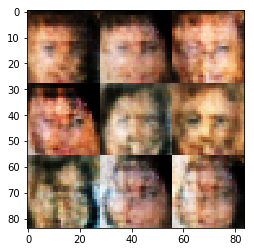

Epoch 1/1... Discriminator Loss: 1.0961... Generator Loss: 0.9076
Epoch 1/1... Discriminator Loss: 1.1778... Generator Loss: 0.9104
Epoch 1/1... Discriminator Loss: 1.2376... Generator Loss: 0.9134
Epoch 1/1... Discriminator Loss: 1.2137... Generator Loss: 1.0323
Epoch 1/1... Discriminator Loss: 1.1777... Generator Loss: 0.9265
Epoch 1/1... Discriminator Loss: 1.4305... Generator Loss: 0.8334
Epoch 1/1... Discriminator Loss: 1.2438... Generator Loss: 0.9593
Epoch 1/1... Discriminator Loss: 1.2156... Generator Loss: 0.8333
Epoch 1/1... Discriminator Loss: 1.2475... Generator Loss: 0.8858
Epoch 1/1... Discriminator Loss: 1.3540... Generator Loss: 1.0275


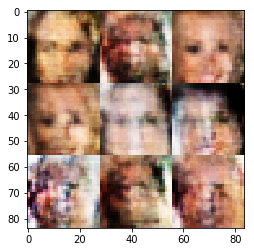

Epoch 1/1... Discriminator Loss: 1.2390... Generator Loss: 0.8962
Epoch 1/1... Discriminator Loss: 1.1571... Generator Loss: 0.8597
Epoch 1/1... Discriminator Loss: 1.1631... Generator Loss: 0.8788
Epoch 1/1... Discriminator Loss: 1.2306... Generator Loss: 1.0288
Epoch 1/1... Discriminator Loss: 1.2291... Generator Loss: 0.8078
Epoch 1/1... Discriminator Loss: 1.2188... Generator Loss: 0.9146
Epoch 1/1... Discriminator Loss: 1.1552... Generator Loss: 0.9310
Epoch 1/1... Discriminator Loss: 1.2120... Generator Loss: 0.9160
Epoch 1/1... Discriminator Loss: 1.1924... Generator Loss: 0.9095
Epoch 1/1... Discriminator Loss: 1.5852... Generator Loss: 1.0337


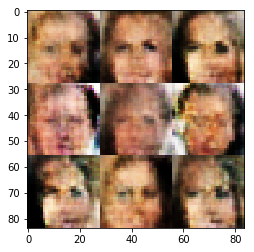

Epoch 1/1... Discriminator Loss: 1.3032... Generator Loss: 0.8364
Epoch 1/1... Discriminator Loss: 1.2280... Generator Loss: 0.8266
Epoch 1/1... Discriminator Loss: 1.1827... Generator Loss: 1.0098
Epoch 1/1... Discriminator Loss: 1.2677... Generator Loss: 0.8721
Epoch 1/1... Discriminator Loss: 1.1724... Generator Loss: 0.9867
Epoch 1/1... Discriminator Loss: 1.3199... Generator Loss: 0.7437
Epoch 1/1... Discriminator Loss: 1.1561... Generator Loss: 0.9452
Epoch 1/1... Discriminator Loss: 1.2556... Generator Loss: 1.0054
Epoch 1/1... Discriminator Loss: 1.1543... Generator Loss: 0.8834
Epoch 1/1... Discriminator Loss: 1.2565... Generator Loss: 0.9125


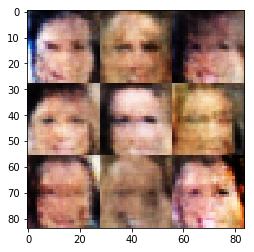

Epoch 1/1... Discriminator Loss: 1.1612... Generator Loss: 0.9391
Epoch 1/1... Discriminator Loss: 1.2567... Generator Loss: 0.8333
Epoch 1/1... Discriminator Loss: 1.1825... Generator Loss: 0.8803
Epoch 1/1... Discriminator Loss: 1.2885... Generator Loss: 0.8985
Epoch 1/1... Discriminator Loss: 1.2761... Generator Loss: 1.0354
Epoch 1/1... Discriminator Loss: 1.2909... Generator Loss: 0.8429
Epoch 1/1... Discriminator Loss: 1.2998... Generator Loss: 0.7530
Epoch 1/1... Discriminator Loss: 1.2331... Generator Loss: 0.9383
Epoch 1/1... Discriminator Loss: 1.2540... Generator Loss: 0.9837
Epoch 1/1... Discriminator Loss: 1.2667... Generator Loss: 0.7840


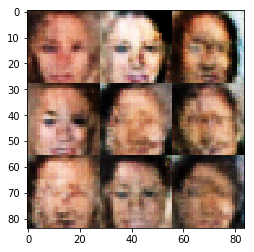

Epoch 1/1... Discriminator Loss: 1.2837... Generator Loss: 0.8127
Epoch 1/1... Discriminator Loss: 2.1812... Generator Loss: 0.9839
Epoch 1/1... Discriminator Loss: 1.1979... Generator Loss: 0.9004
Epoch 1/1... Discriminator Loss: 1.8175... Generator Loss: 1.2164
Epoch 1/1... Discriminator Loss: 1.2330... Generator Loss: 0.8543
Epoch 1/1... Discriminator Loss: 1.1898... Generator Loss: 1.1218
Epoch 1/1... Discriminator Loss: 1.2241... Generator Loss: 0.8817
Epoch 1/1... Discriminator Loss: 1.2673... Generator Loss: 0.8437
Epoch 1/1... Discriminator Loss: 1.2642... Generator Loss: 0.8948
Epoch 1/1... Discriminator Loss: 1.1961... Generator Loss: 0.9090


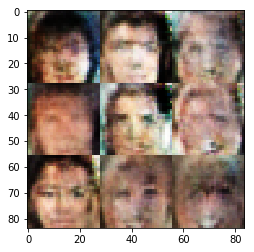

Epoch 1/1... Discriminator Loss: 1.2898... Generator Loss: 0.8314
Epoch 1/1... Discriminator Loss: 1.2373... Generator Loss: 0.8248
Epoch 1/1... Discriminator Loss: 1.2481... Generator Loss: 0.8747
Epoch 1/1... Discriminator Loss: 1.2747... Generator Loss: 0.8389
Epoch 1/1... Discriminator Loss: 1.2635... Generator Loss: 0.8446
Epoch 1/1... Discriminator Loss: 1.2252... Generator Loss: 0.8212
Epoch 1/1... Discriminator Loss: 1.2429... Generator Loss: 0.8616
Epoch 1/1... Discriminator Loss: 1.2348... Generator Loss: 0.8818
Epoch 1/1... Discriminator Loss: 1.2896... Generator Loss: 0.8822
Epoch 1/1... Discriminator Loss: 1.3179... Generator Loss: 0.8599


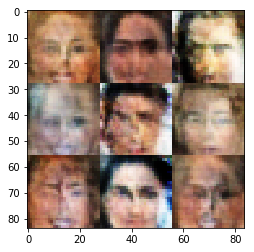

Epoch 1/1... Discriminator Loss: 1.2795... Generator Loss: 0.8591
Epoch 1/1... Discriminator Loss: 1.3360... Generator Loss: 0.8572
Epoch 1/1... Discriminator Loss: 1.3044... Generator Loss: 0.9652
Epoch 1/1... Discriminator Loss: 1.3067... Generator Loss: 0.8117
Epoch 1/1... Discriminator Loss: 1.3151... Generator Loss: 0.8345
Epoch 1/1... Discriminator Loss: 1.2685... Generator Loss: 0.8528
Epoch 1/1... Discriminator Loss: 1.2950... Generator Loss: 0.8945
Epoch 1/1... Discriminator Loss: 1.2729... Generator Loss: 0.8307
Epoch 1/1... Discriminator Loss: 1.2963... Generator Loss: 0.7898
Epoch 1/1... Discriminator Loss: 1.2010... Generator Loss: 0.8259


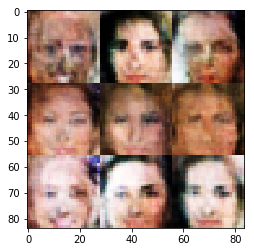

Epoch 1/1... Discriminator Loss: 1.3205... Generator Loss: 0.7603
Epoch 1/1... Discriminator Loss: 1.3115... Generator Loss: 0.8598
Epoch 1/1... Discriminator Loss: 1.2246... Generator Loss: 0.8762
Epoch 1/1... Discriminator Loss: 1.2866... Generator Loss: 0.7858
Epoch 1/1... Discriminator Loss: 1.2790... Generator Loss: 0.8032
Epoch 1/1... Discriminator Loss: 1.2780... Generator Loss: 0.8451
Epoch 1/1... Discriminator Loss: 1.3324... Generator Loss: 0.8944
Epoch 1/1... Discriminator Loss: 1.3556... Generator Loss: 0.9487
Epoch 1/1... Discriminator Loss: 2.4569... Generator Loss: 0.8282
Epoch 1/1... Discriminator Loss: 1.3345... Generator Loss: 0.8317


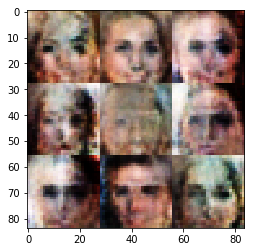

Epoch 1/1... Discriminator Loss: 1.3054... Generator Loss: 0.8084
Epoch 1/1... Discriminator Loss: 1.2930... Generator Loss: 0.8274
Epoch 1/1... Discriminator Loss: 1.2929... Generator Loss: 0.8715
Epoch 1/1... Discriminator Loss: 1.2724... Generator Loss: 0.9142
Epoch 1/1... Discriminator Loss: 1.2832... Generator Loss: 0.7114
Epoch 1/1... Discriminator Loss: 1.2580... Generator Loss: 0.8508
Epoch 1/1... Discriminator Loss: 1.3344... Generator Loss: 0.7877
Epoch 1/1... Discriminator Loss: 1.2397... Generator Loss: 0.8652
Epoch 1/1... Discriminator Loss: 1.2295... Generator Loss: 0.8730
Epoch 1/1... Discriminator Loss: 1.3356... Generator Loss: 0.7144


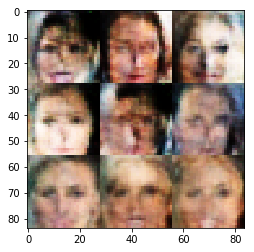

Epoch 1/1... Discriminator Loss: 1.2612... Generator Loss: 0.8444
Epoch 1/1... Discriminator Loss: 1.2840... Generator Loss: 0.8525
Epoch 1/1... Discriminator Loss: 1.2752... Generator Loss: 0.7456
Epoch 1/1... Discriminator Loss: 1.2709... Generator Loss: 0.7707
Epoch 1/1... Discriminator Loss: 1.3135... Generator Loss: 0.7509
Epoch 1/1... Discriminator Loss: 1.3118... Generator Loss: 0.8361
Epoch 1/1... Discriminator Loss: 1.3192... Generator Loss: 0.8032
Epoch 1/1... Discriminator Loss: 1.2852... Generator Loss: 0.7977
Epoch 1/1... Discriminator Loss: 1.2851... Generator Loss: 0.8205
Epoch 1/1... Discriminator Loss: 1.2537... Generator Loss: 0.8850


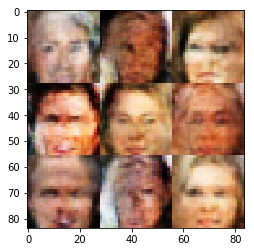

Epoch 1/1... Discriminator Loss: 1.2615... Generator Loss: 0.8475
Epoch 1/1... Discriminator Loss: 1.3677... Generator Loss: 0.8956
Epoch 1/1... Discriminator Loss: 1.3102... Generator Loss: 0.8188
Epoch 1/1... Discriminator Loss: 1.2736... Generator Loss: 0.9660
Epoch 1/1... Discriminator Loss: 1.2904... Generator Loss: 0.8117
Epoch 1/1... Discriminator Loss: 1.3367... Generator Loss: 0.8005
Epoch 1/1... Discriminator Loss: 1.3553... Generator Loss: 0.7995
Epoch 1/1... Discriminator Loss: 1.3007... Generator Loss: 0.8560
Epoch 1/1... Discriminator Loss: 1.3754... Generator Loss: 0.7935
Epoch 1/1... Discriminator Loss: 1.3417... Generator Loss: 0.7621


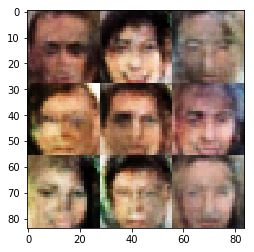

Epoch 1/1... Discriminator Loss: 1.2959... Generator Loss: 0.8304
Epoch 1/1... Discriminator Loss: 1.4502... Generator Loss: 0.8263
Epoch 1/1... Discriminator Loss: 1.3275... Generator Loss: 0.7816
Epoch 1/1... Discriminator Loss: 1.6834... Generator Loss: 0.8362
Epoch 1/1... Discriminator Loss: 1.7438... Generator Loss: 1.0755
Epoch 1/1... Discriminator Loss: 1.2768... Generator Loss: 0.8816
Epoch 1/1... Discriminator Loss: 1.3185... Generator Loss: 0.8506
Epoch 1/1... Discriminator Loss: 1.2789... Generator Loss: 0.7756
Epoch 1/1... Discriminator Loss: 1.2449... Generator Loss: 0.8342
Epoch 1/1... Discriminator Loss: 1.3904... Generator Loss: 0.8438


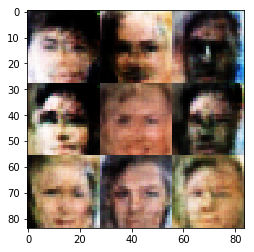

Epoch 1/1... Discriminator Loss: 1.3130... Generator Loss: 0.8245
Epoch 1/1... Discriminator Loss: 1.2186... Generator Loss: 0.8473
Epoch 1/1... Discriminator Loss: 1.2894... Generator Loss: 0.8317
Epoch 1/1... Discriminator Loss: 1.3014... Generator Loss: 0.8359
Epoch 1/1... Discriminator Loss: 1.3389... Generator Loss: 0.8632
Epoch 1/1... Discriminator Loss: 1.3604... Generator Loss: 0.8090
Epoch 1/1... Discriminator Loss: 1.3156... Generator Loss: 0.9142
Epoch 1/1... Discriminator Loss: 1.3583... Generator Loss: 0.7804
Epoch 1/1... Discriminator Loss: 1.3578... Generator Loss: 0.8334
Epoch 1/1... Discriminator Loss: 1.3022... Generator Loss: 0.8123


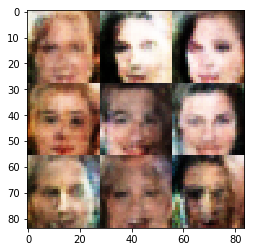

Epoch 1/1... Discriminator Loss: 1.3544... Generator Loss: 0.7933
Epoch 1/1... Discriminator Loss: 1.3064... Generator Loss: 0.7548
Epoch 1/1... Discriminator Loss: 1.3240... Generator Loss: 0.7929
Epoch 1/1... Discriminator Loss: 1.3250... Generator Loss: 0.7652
Epoch 1/1... Discriminator Loss: 1.3005... Generator Loss: 0.8007
Epoch 1/1... Discriminator Loss: 1.3348... Generator Loss: 0.8472
Epoch 1/1... Discriminator Loss: 1.3431... Generator Loss: 0.7696
Epoch 1/1... Discriminator Loss: 1.3213... Generator Loss: 0.8188
Epoch 1/1... Discriminator Loss: 1.3269... Generator Loss: 0.7426
Epoch 1/1... Discriminator Loss: 1.3177... Generator Loss: 0.8224


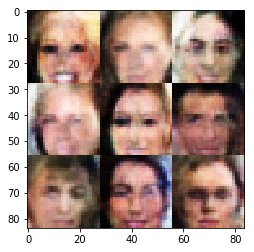

Epoch 1/1... Discriminator Loss: 1.3815... Generator Loss: 0.8267
Epoch 1/1... Discriminator Loss: 1.3159... Generator Loss: 0.7973
Epoch 1/1... Discriminator Loss: 1.2591... Generator Loss: 0.8773
Epoch 1/1... Discriminator Loss: 1.3313... Generator Loss: 0.8717
Epoch 1/1... Discriminator Loss: 1.3094... Generator Loss: 0.7968
Epoch 1/1... Discriminator Loss: 1.3008... Generator Loss: 0.7659
Epoch 1/1... Discriminator Loss: 1.3020... Generator Loss: 0.7881
Epoch 1/1... Discriminator Loss: 1.6747... Generator Loss: 0.5561
Epoch 1/1... Discriminator Loss: 1.3938... Generator Loss: 0.7844
Epoch 1/1... Discriminator Loss: 1.7018... Generator Loss: 0.8934


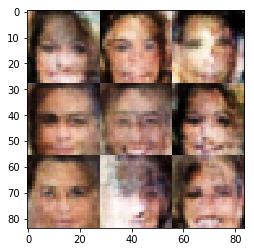

Epoch 1/1... Discriminator Loss: 1.3153... Generator Loss: 0.8281
Epoch 1/1... Discriminator Loss: 1.3384... Generator Loss: 0.7982
Epoch 1/1... Discriminator Loss: 1.3059... Generator Loss: 0.8743
Epoch 1/1... Discriminator Loss: 1.3136... Generator Loss: 0.8038
Epoch 1/1... Discriminator Loss: 1.2866... Generator Loss: 0.8536
Epoch 1/1... Discriminator Loss: 1.3423... Generator Loss: 0.7707
Epoch 1/1... Discriminator Loss: 1.2971... Generator Loss: 0.7654
Epoch 1/1... Discriminator Loss: 1.2849... Generator Loss: 0.8132
Epoch 1/1... Discriminator Loss: 1.3321... Generator Loss: 0.7864
Epoch 1/1... Discriminator Loss: 1.2960... Generator Loss: 0.8514


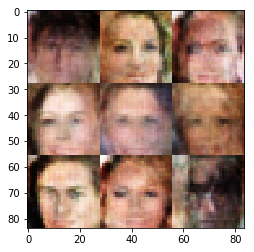

Epoch 1/1... Discriminator Loss: 1.3316... Generator Loss: 0.8112
Epoch 1/1... Discriminator Loss: 1.3300... Generator Loss: 0.7917
Epoch 1/1... Discriminator Loss: 1.2749... Generator Loss: 0.7667
Epoch 1/1... Discriminator Loss: 1.2295... Generator Loss: 0.8847
Epoch 1/1... Discriminator Loss: 1.3338... Generator Loss: 0.8213
Epoch 1/1... Discriminator Loss: 1.3427... Generator Loss: 0.7656
Epoch 1/1... Discriminator Loss: 1.2958... Generator Loss: 0.8552
Epoch 1/1... Discriminator Loss: 1.3567... Generator Loss: 0.7890
Epoch 1/1... Discriminator Loss: 1.2804... Generator Loss: 0.8540
Epoch 1/1... Discriminator Loss: 1.2988... Generator Loss: 0.7748


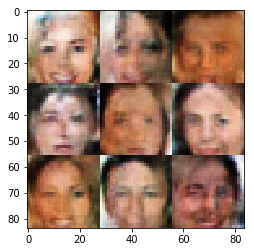

Epoch 1/1... Discriminator Loss: 1.3498... Generator Loss: 0.8171
Epoch 1/1... Discriminator Loss: 1.2691... Generator Loss: 0.8500
Epoch 1/1... Discriminator Loss: 1.3300... Generator Loss: 0.8099
Epoch 1/1... Discriminator Loss: 1.3432... Generator Loss: 0.7770
Epoch 1/1... Discriminator Loss: 1.4852... Generator Loss: 0.7798
Epoch 1/1... Discriminator Loss: 1.3170... Generator Loss: 0.7696
Epoch 1/1... Discriminator Loss: 1.3035... Generator Loss: 0.8140
Epoch 1/1... Discriminator Loss: 1.2854... Generator Loss: 0.8582
Epoch 1/1... Discriminator Loss: 1.2932... Generator Loss: 0.8257
Epoch 1/1... Discriminator Loss: 1.3469... Generator Loss: 0.7761


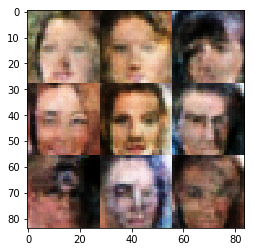

Epoch 1/1... Discriminator Loss: 1.3154... Generator Loss: 0.7985
Epoch 1/1... Discriminator Loss: 1.3367... Generator Loss: 0.7747
Epoch 1/1... Discriminator Loss: 1.3256... Generator Loss: 0.8629
Epoch 1/1... Discriminator Loss: 1.3400... Generator Loss: 0.8007
Epoch 1/1... Discriminator Loss: 1.3159... Generator Loss: 0.8100
Epoch 1/1... Discriminator Loss: 1.3686... Generator Loss: 0.8298
Epoch 1/1... Discriminator Loss: 1.3735... Generator Loss: 0.8450
Epoch 1/1... Discriminator Loss: 1.3293... Generator Loss: 0.7936
Epoch 1/1... Discriminator Loss: 1.3121... Generator Loss: 0.8312
Epoch 1/1... Discriminator Loss: 1.3117... Generator Loss: 0.8006


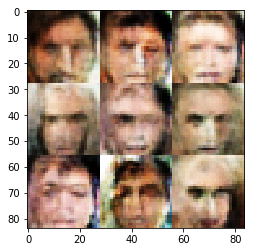

Epoch 1/1... Discriminator Loss: 1.3098... Generator Loss: 0.8445
Epoch 1/1... Discriminator Loss: 1.3085... Generator Loss: 0.7845
Epoch 1/1... Discriminator Loss: 1.3151... Generator Loss: 0.8224
Epoch 1/1... Discriminator Loss: 1.2745... Generator Loss: 0.7828
Epoch 1/1... Discriminator Loss: 1.3057... Generator Loss: 0.8081
Epoch 1/1... Discriminator Loss: 1.2777... Generator Loss: 0.8038
Epoch 1/1... Discriminator Loss: 1.3025... Generator Loss: 0.8341
Epoch 1/1... Discriminator Loss: 1.4696... Generator Loss: 0.6369
Epoch 1/1... Discriminator Loss: 1.9649... Generator Loss: 1.0053
Epoch 1/1... Discriminator Loss: 1.4288... Generator Loss: 0.6810


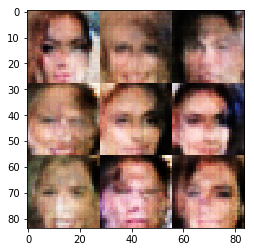

Epoch 1/1... Discriminator Loss: 1.2433... Generator Loss: 0.8656
Epoch 1/1... Discriminator Loss: 1.2685... Generator Loss: 0.7971
Epoch 1/1... Discriminator Loss: 1.2940... Generator Loss: 0.8361
Epoch 1/1... Discriminator Loss: 1.2628... Generator Loss: 0.8893
Epoch 1/1... Discriminator Loss: 1.3301... Generator Loss: 0.8462
Epoch 1/1... Discriminator Loss: 1.3252... Generator Loss: 0.8468
Epoch 1/1... Discriminator Loss: 1.5326... Generator Loss: 0.9054
Epoch 1/1... Discriminator Loss: 1.2857... Generator Loss: 0.8064
Epoch 1/1... Discriminator Loss: 1.3328... Generator Loss: 0.7540
Epoch 1/1... Discriminator Loss: 1.2958... Generator Loss: 0.8499


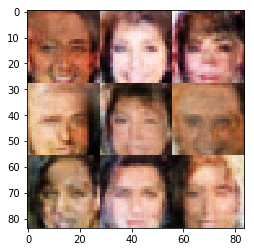

Epoch 1/1... Discriminator Loss: 1.2836... Generator Loss: 0.8163
Epoch 1/1... Discriminator Loss: 1.3033... Generator Loss: 0.8513
Epoch 1/1... Discriminator Loss: 1.3086... Generator Loss: 0.8106
Epoch 1/1... Discriminator Loss: 1.2897... Generator Loss: 0.8285
Epoch 1/1... Discriminator Loss: 1.3111... Generator Loss: 0.8162
Epoch 1/1... Discriminator Loss: 1.3326... Generator Loss: 0.8304
Epoch 1/1... Discriminator Loss: 1.3203... Generator Loss: 0.8451
Epoch 1/1... Discriminator Loss: 1.3024... Generator Loss: 0.8137
Epoch 1/1... Discriminator Loss: 1.3437... Generator Loss: 0.7614
Epoch 1/1... Discriminator Loss: 1.3413... Generator Loss: 0.7634


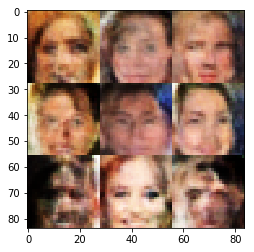

Epoch 1/1... Discriminator Loss: 1.2976... Generator Loss: 0.8125
Epoch 1/1... Discriminator Loss: 1.2814... Generator Loss: 0.8592
Epoch 1/1... Discriminator Loss: 1.3070... Generator Loss: 0.7681
Epoch 1/1... Discriminator Loss: 1.3518... Generator Loss: 0.7695
Epoch 1/1... Discriminator Loss: 1.2908... Generator Loss: 0.8041
Epoch 1/1... Discriminator Loss: 1.3103... Generator Loss: 0.8384


In [20]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.